# Path of Steepest Ascent — Python Tutorial
A hands-on, step-by-step tutorial showing how to find and use the **path of steepest ascent** to improve a process in Python.

## Setup

Run this cell. If you get import errors, uncomment the `%pip install` line.

In [70]:
# %pip install --quiet numpy pandas matplotlib statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Set pandas to display floating-point numbers with 3 decimal places for cleaner output
pd.set_option("display.precision", 3)

In [71]:
### Helper function for contour plots ###

def plot_contour(X, Y, Z, data, x_col, y_col, response_col, title, xlabel, ylabel):
    """Create a contour plot with data points overlaid."""
    plt.figure(figsize=(8, 6))
    contour = plt.contour(X, Y, Z, levels=10, cmap="viridis")
    plt.colorbar(contour)
    
    # Add data points
    plt.scatter(data[x_col], data[y_col], c=data[response_col], 
               cmap='plasma', s=50, edgecolor='black', linewidth=0.5)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

# Example 1: Plasma etching process

**Scenario**  
We study a plasma etching process. The **response** is the **etch rate** (Å/min).  
Two **inputs (factors)** control it:
- `gap` (anode–cathode distance, in cm)
- `power` (cathode power, in W)

**Goal**  
Increase etch rate and reach about **1000 Å/min**.

**Current process**  
The process currently runs at the center point: `gap = 1.4 cm` and `power = 300 W`, achieving an average etch rate of approximately **750 Å/min**.

**Experimental range**  
To explore improvement opportunities, we tested a ±0.2 cm range for gap (1.2–1.6 cm) and a ±25 W range for power (275–325 W). This 2² factorial design with center points will help us model the local response surface and determine the direction for process improvement.

In [72]:
### Load the dataset ###
plasma = pd.read_csv("plasma.csv")
plasma # x1=coded gap; x2=coded power; etch=response

,gap,power,x1,x2,etch
0,1.2,275,-1,-1,775
1,1.6,275,1,-1,670
2,1.2,325,-1,1,890
3,1.6,325,1,1,730
4,1.4,300,0,0,745
5,1.4,300,0,0,760
6,1.4,300,0,0,780
7,1.4,300,0,0,720


In [73]:
### Fit a first-order linear regression model ###

# Interaction term is not significant
# fit_int = smf.ols("etch ~ x1 + x2 + I(x1 * x2)", data=plasma).fit()
# print(fit_int.summary())

fit_int = smf.ols("etch ~ x1 + x2", data=plasma).fit()
print(fit_int.summary())

                            OLS Regression Results                            
Dep. Variable:                   etch   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     20.17
Date:                Fri, 31 Oct 2025   Prob (F-statistic):            0.00404
Time:                        23:33:35   Log-Likelihood:                -35.223
No. Observations:                   8   AIC:                             76.45
Df Residuals:                       5   BIC:                             76.68
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    758.7500      8.839     85.843      0.0

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


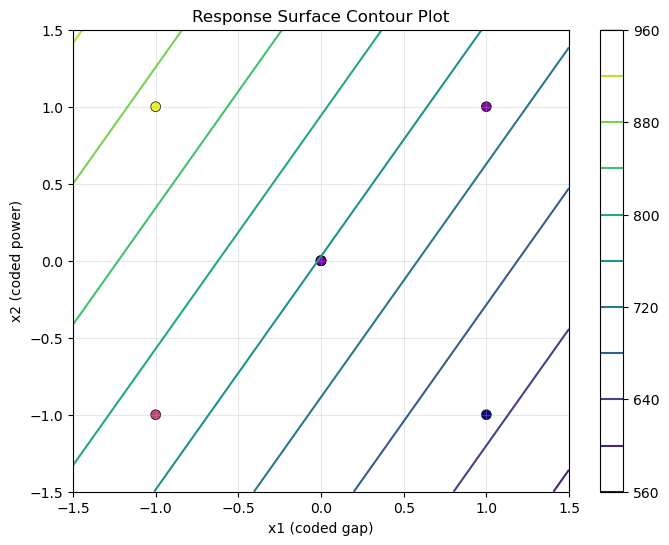

In [74]:
### Visualize the model fit ###

# Get coefficients and create response surface
b0 = fit_int.params["Intercept"]
b1 = fit_int.params["x1"] 
b2 = fit_int.params["x2"]

x = np.linspace(-1.5, 1.5, 50)
X1, X2 = np.meshgrid(x, x)
Z = b0 + b1 * X1 + b2 * X2

# Create contour plot
plot_contour(X1, X2, Z, plasma, 'x1', 'x2', 'etch', 
            'Response Surface Contour Plot', 'x1 (coded gap)', 'x2 (coded power)')

In [75]:
### Determine the path of steepest ascent ###

'''
For a linear model, the path of steepest ascent is the direction in which the
predicted response increases the fastest. Mathematically, this direction is
given by the gradient vector of the fitted response surface.

If we have a first-order (linear) model of the form:

    ŷ = b0 + b1*x1 + b2*x2

then the gradient vector is simply:

    g = (b1, b2)

Each slope coefficient (b1, b2) represents how sensitively the response changes
with respect to its factor. The gradient points in the direction where the
combined change in x1 and x2 causes the largest increase in ŷ.

In other words:
- b1 tells us how much ŷ changes for a unit increase in x1 (holding x2 constant),
- b2 tells us the same for x2,
- and the ratio b2/b1 tells us how much to change x2 for each unit change in x1
  if we want to move "straight uphill" along the response surface.

This direction vector is what we follow step-by-step in a path of steepest ascent
experiment.
'''

# Get coefficients
b0 = fit_int.params["Intercept"]
b1 = fit_int.params["x1"] # slope in x1 direction
b2 = fit_int.params["x2"] # slope in x2 direction
print(f"Coefficients: b0={b0:.3f}, b1={b1:.3f}, b2={b2:.3f}")

# Calculate slope ratio
slope_ratio = (b2 / b1)
print(f"Slope ratio (b2/b1): {slope_ratio:.3f}")

Coefficients: b0=758.750, b1=-66.250, b2=43.750
Slope ratio (b2/b1): -0.660


In [76]:
# Choose concrete steps, due to the coefficients' signs we choose negative steps for x1
step_size_x1 = np.array([0, -1, -2, -3]) # You can adjust this as needed

# and calculate corresponding steps in x2 direction
step_size_x2 = slope_ratio * step_size_x1

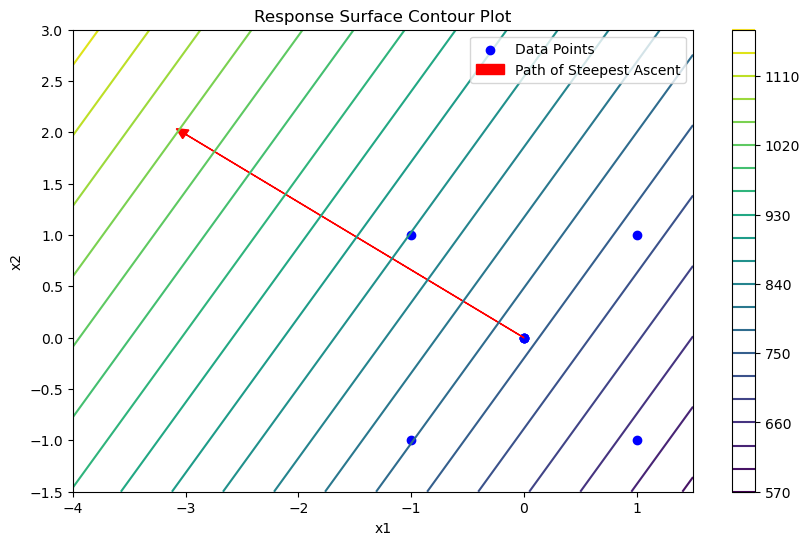

In [77]:
### Visualize the path of steepest ascent ###

'''
We can visualize the path of steepest ascent within our contour plot of the response surface.
This helps to see how the path moves through the factor space towards higher response values.
'''

# Create a grid of x1 and x2 values; extending the ranges to better visualize the path of steepest ascent
x1_range = np.linspace(-4, 1.5, 100)
x2_range = np.linspace(-1.5, 3, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Calculate the response surface
Z = b0 + b1 * X1 + b2 * X2

# Plot the contour
plt.figure(figsize=(10, 6))
contour = plt.contour(X1, X2, Z, levels=20, cmap="viridis")
plt.colorbar(contour)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Response Surface Contour Plot")

# Add the original data points
plt.scatter(plasma["x1"], plasma["x2"], c='blue', label='Data Points')

# Overlay the path of steepest ascent
# plt.plot(step_size_x1, step_size_x2, marker='o', color='red', label='Path of Steepest Ascent')
plt.arrow(0, 0, step_size_x1[-1], step_size_x2[-1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='Path of Steepest Ascent')
plt.legend()

plt.show()

# Example 2: Filtration rate experiment


**Scenario**  
We study a filtration process. The **response** is the **filtration rate** (units/time).  
Four **inputs (factors)** control it:
- `T` (Temperature)
- `P` (Pressure)
- `CoF` (Concentration of Formaldehyde)
- `RPM` (Stirring Rate)

**Goal**  
Optimize the filtration rate to achieve maximum efficiency.

**Experimental design**  
We conducted a 2⁴ factorial design to explore the factor space and model the response surface. This will help us determine the direction for process improvement using the path of steepest ascent.

In [78]:
### Load the filtration dataset ###
filtration = pd.read_csv("filtration.csv")

In [79]:
### Fit a first-order linear regression model ###

fit_filtration = smf.ols("Filtration_rate ~ T + CoF + RPM + I(T*CoF) + I(T*RPM)", data=filtration).fit()
print(fit_filtration.summary())

                            OLS Regression Results                            
Dep. Variable:        Filtration_rate   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     56.74
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           5.14e-07
Time:                        23:33:35   Log-Likelihood:                -42.711
No. Observations:                  16   AIC:                             97.42
Df Residuals:                      10   BIC:                             102.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.0625      1.104     63.444      0.0

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


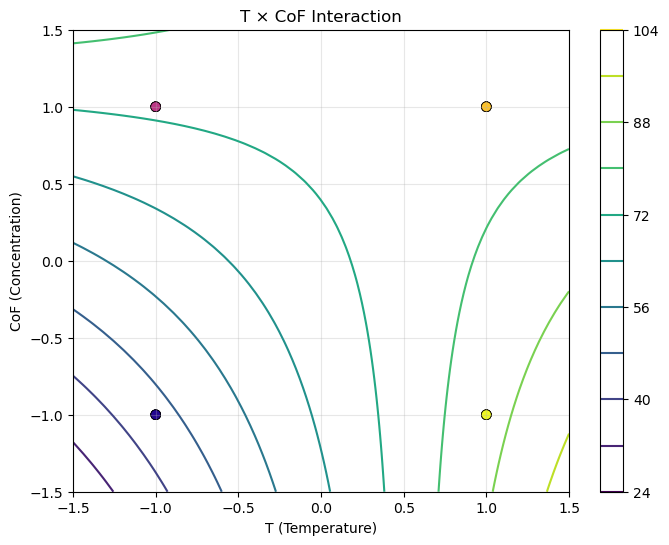

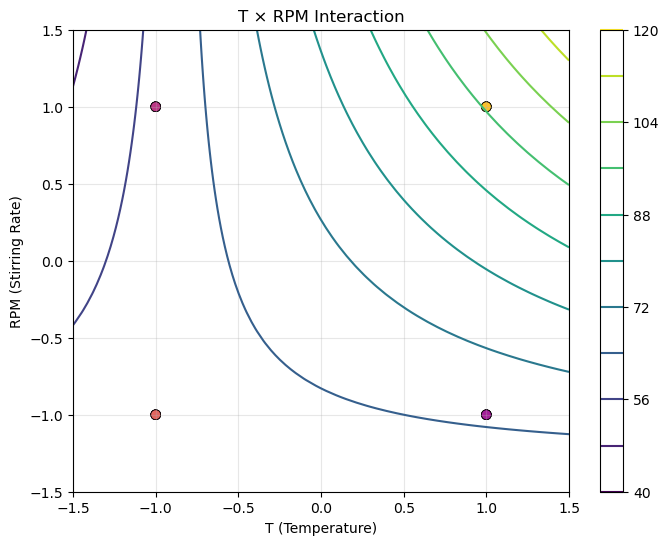

In [80]:
### Visualize the model fit ###

# Get coefficients
b0 = fit_filtration.params["Intercept"]
b_T = fit_filtration.params["T"]
b_CoF = fit_filtration.params["CoF"] 
b_RPM = fit_filtration.params["RPM"]
b_T_CoF = fit_filtration.params["I(T * CoF)"]
b_T_RPM = fit_filtration.params["I(T * RPM)"]

# Create grids and response surfaces
x = np.linspace(-1.5, 1.5, 50)
X, Y = np.meshgrid(x, x)
Z1 = b0 + b_T*X + b_CoF*Y + b_T_CoF*X*Y  # T vs CoF
Z2 = b0 + b_T*X + b_RPM*Y + b_T_RPM*X*Y  # T vs RPM

# Create contour plots
plot_contour(X, Y, Z1, filtration, 'T', 'CoF', 'Filtration_rate',
            'T × CoF Interaction', 'T (Temperature)', 'CoF (Concentration)')

plot_contour(X, Y, Z2, filtration, 'T', 'RPM', 'Filtration_rate',
            'T × RPM Interaction', 'T (Temperature)', 'RPM (Stirring Rate)')